In [ ]:
import os, glob, cv2, math
from tqdm import tqdm
from PIL import Image
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device=='cuda':
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory/1024**3:.1f} GB")

hr_size = (1024,1024)
scale=8
data_root = "/content/drive/MyDrive/stare_images"

class STARE(Dataset):
    def __init__(self, files, hr_size, scale=8):
        self.files = files
        self.hr_size = hr_size
        self.scale = scale
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        hr = Image.open(self.files[i]).convert('RGB')
        hr = hr.resize(self.hr_size, Image.BICUBIC)
        lr = hr.resize((self.hr_size[0]//self.scale, self.hr_size[1]//self.scale), Image.BICUBIC)
        hr_t = torch.from_numpy(np.array(hr)).permute(2,0,1).float()/255.
        lr_t = torch.from_numpy(np.array(lr)).permute(2,0,1).float()/255.
        return lr_t, hr_t

all_files = sorted(glob.glob(os.path.join(data_root,"*.png")))
train_ds = STARE(all_files[:377], hr_size, scale=8)
test_ds  = STARE(all_files[377:], hr_size, scale=8)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False)

#Proposed Model
class ImprovedSEBlock(nn.Module):
    def __init__(self, c, r=16, k1=0.8, k2=0.2):
        super().__init__()
        self.k1,self.k2 = k1,k2
        self.fc1 = nn.Linear(c, c//r, True)
        self.fc2 = nn.Linear(c//r, c, True)
        self.relu=nn.ReLU(True)
    def forward(self,x):
        N,C,H,W = x.size()
        y = x.view(N,C,-1).mean(-1)
        se = torch.sigmoid(self.fc2(self.relu(self.fc1(y))))
        inp = torch.sigmoid(y)
        s = (self.k1*se + self.k2*inp)*2
        s = s.view(N,C,1,1)
        return x * s

class SEResBlock(nn.Module):
    def __init__(self, channels):
        super(SEResBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.se    = ImprovedSEBlock(channels)
    def forward(self,x):
        out = self.conv1(x); out = self.relu(out)
        out = self.conv2(out); out = self.se(out)
        return x + out

class ProposedGen(nn.Module):
    def __init__(self,scale=8, n_blocks=16, n_feats=64):
        super().__init__()
        self.head = nn.Conv2d(3,n_feats,3,1,1)
        self.body = nn.Sequential(*[SEResBlock(n_feats) for _ in range(n_blocks)])
        self.body_conv = nn.Conv2d(n_feats, n_feats,3,1,1)
        up_steps = int(math.log2(scale))
        tail=[]
        for _ in range(up_steps):
            tail += [nn.Conv2d(n_feats, n_feats*4,3,1,1),
                     nn.PixelShuffle(2), nn.ReLU(True)]
        tail += [nn.Conv2d(n_feats,3,3,1,1)]
        self.up = nn.Sequential(*tail)
    def forward(self,x):
        x1 = self.head(x)
        res = self.body(x1)
        res = self.body_conv(res)
        res = res + x1
        return self.up(res)

gen = ProposedGen(scale=8).to(device)
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)
l1 = nn.L1Loss()

# Training
epochs = 100
for ep in range(epochs):
    gen.train()
    loop = tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs}")
    for lr, hr in loop:
        lr,hr = lr.to(device), hr.to(device)
        sr = gen(lr)
        loss = l1(sr, hr)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        loop.set_postfix(loss=loss.item())
# Evaluation
def eval_model(model, need_up=False):
    model.eval()
    ps, ss = [], []
    with torch.no_grad():
        for lr, hr in test_loader:
            lr,hr = lr.to(device), hr.to(device)
            inp = F.interpolate(lr, size=hr_size, mode='bicubic', align_corners=False) if need_up else lr
            out = model(inp) if not need_up else model(lr)
            if out.shape[-2:] != hr.shape[-2:]:
                out = F.interpolate(out, size=hr.shape[-2:], mode='bicubic', align_corners=False)
            out_np = (out.clamp(0,1).cpu().permute(0,2,3,1).numpy()*255).astype(np.uint8)[0]
            hr_np  = (hr.cpu().permute(0,2,3,1).numpy()*255).astype(np.uint8)[0]
            ps.append(compare_psnr(hr_np, out_np, data_range=255))
            ss.append(compare_ssim(hr_np, out_np, channel_axis=-1, data_range=255))
    return np.mean(ps), np.mean(ss)

results = {}
ps,ss = [],[]
for lr, hr in test_loader:
    lr_np = (lr.cpu().permute(0,2,3,1).numpy()*255).astype(np.uint8)[0]
    bic = cv2.resize(lr_np, hr_size, interpolation=cv2.INTER_CUBIC)
    hr_np = (hr.cpu().permute(0,2,3,1).numpy()*255).astype(np.uint8)[0]
    ps.append(compare_psnr(hr_np, bic, data_range=255))
    ss.append(compare_ssim(hr_np, bic, channel_axis=-1, data_range=255))
results['Bicubic'] = (np.mean(ps), np.mean(ss))
results['Proposed']  = eval_model(gen)

print("\nAverage PSNR / SSIM on STARE x8:")
for k,(p,s_) in results.items():
    print(f"{k:10s}:  PSNR = {p:5.2f} dB,   SSIM = {s_:0.4f}")

Using device: cuda
Total GPU memory: 14.7 GB


Epoch 100/100: 100%|██████████| 94/94 [01:18<00:00,  1.19it/s, loss=0.00645]



Average PSNR / SSIM on STARE ×8:
Bicubic   :  PSNR = 35.41 dB,   SSIM = 0.9195
Proposed  :  PSNR = 39.88 dB,   SSIM = 0.9330


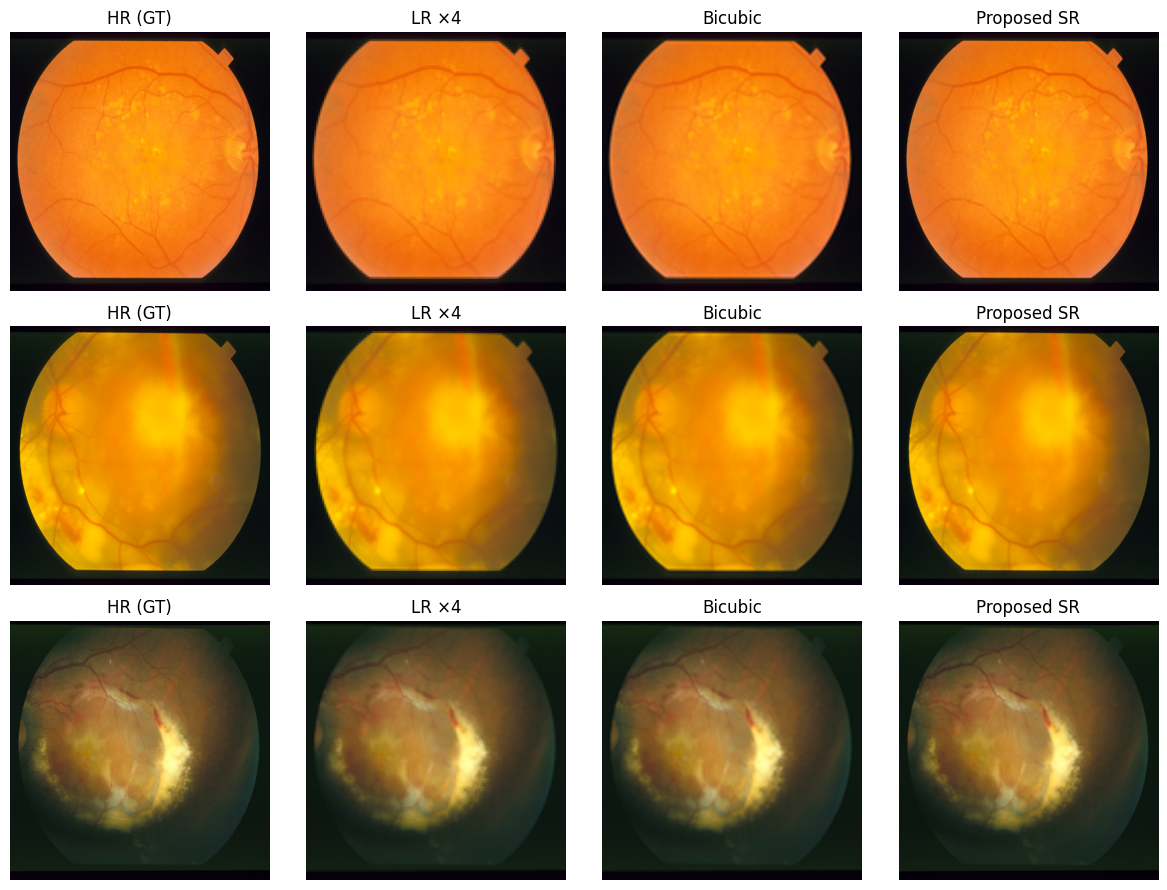

In [ ]:
import matplotlib.pyplot as plt

n_samples = 3

samples = []
for idx, (lr, hr) in enumerate(test_loader):
    samples.append((lr, hr))
    if idx + 1 >= n_samples:
        break

fig, axes = plt.subplots(n_samples, 4, figsize=(12, 3 * n_samples))

for i, (lr, hr) in enumerate(samples):
    lr, hr = lr.to(device), hr.to(device)

    with torch.no_grad():
        sr_prop = gen(lr)

    hr_np   = (hr.cpu().permute(0,2,3,1).numpy() * 255).astype(np.uint8)[0]
    lr_np   = (lr.cpu().permute(0,2,3,1).numpy() * 255).astype(np.uint8)[0]
    bic_np  = cv2.resize(lr_np, hr_size, interpolation=cv2.INTER_CUBIC)
    prop_np = (sr_prop.clamp(0,1).cpu().permute(0,2,3,1).numpy() * 255).astype(np.uint8)[0]

    axes[i,0].imshow(hr_np)
    axes[i,0].set_title("HR (GT)")
    axes[i,1].imshow(lr_np)
    axes[i,1].set_title("LR x8")
    axes[i,2].imshow(bic_np)
    axes[i,2].set_title("Bicubic")
    axes[i,3].imshow(prop_np)
    axes[i,3].set_title("Proposed SR")

    for j in range(4):
        axes[i,j].axis("off")

plt.tight_layout()
plt.show()